# Control design

<style>
.MathJax {
  font-family: "Common HTML";
}
</style>

$$
\newcommand{\eg}{{\it e.g.}}
\newcommand{\ie}{{\it i.e.}}
\newcommand{\argmin}{\operatornamewithlimits{argmin}}
\newcommand{\mc}{\mathcal}
\newcommand{\mb}{\mathbb}
\newcommand{\mf}{\mathbf}
\newcommand{\minimize}{{\text{minimize}}}
\newcommand{\diag}{{\text{diag}}}
\newcommand{\cond}{{\text{cond}}}
\newcommand{\rank}{{\text{rank }}}
\newcommand{\range}{{\mathcal{R}}}
\newcommand{\null}{{\mathcal{N}}}
\newcommand{\tr}{{\text{trace}}}
\newcommand{\dom}{{\text{dom}}}
\newcommand{\dist}{{\text{dist}}}
\newcommand{\R}{\mathbf{R}}
\newcommand{\SM}{\mathbf{S}}
\newcommand{\ball}{\mathcal{B}}
\newcommand{\bmat}[1]{\begin{bmatrix}#1\end{bmatrix}}
\newcommand{\loss}{\ell}
\newcommand{\eloss}{\mc{L}}
\newcommand{\abs}[1]{| #1 |}
\newcommand{\norm}[1]{\| #1 \|}
\newcommand{\tp}{T}
$$

__<div style="text-align: right"> ASE3001: Computational Experiments for Aerospace Engineering, Inha University. </div>__
_<div style="text-align: right"> Jong-Han Kim (jonghank@inha.ac.kr) </div>_
_<div style="text-align: right"> Seungyeop Lee (seungyeoplee@inha.edu) </div>_


<br>

___

<br>

A control system is designed to bring a target to a desired state and undergoes various verification procedures before practical implementation. Typically, the development of a control system involves the following process

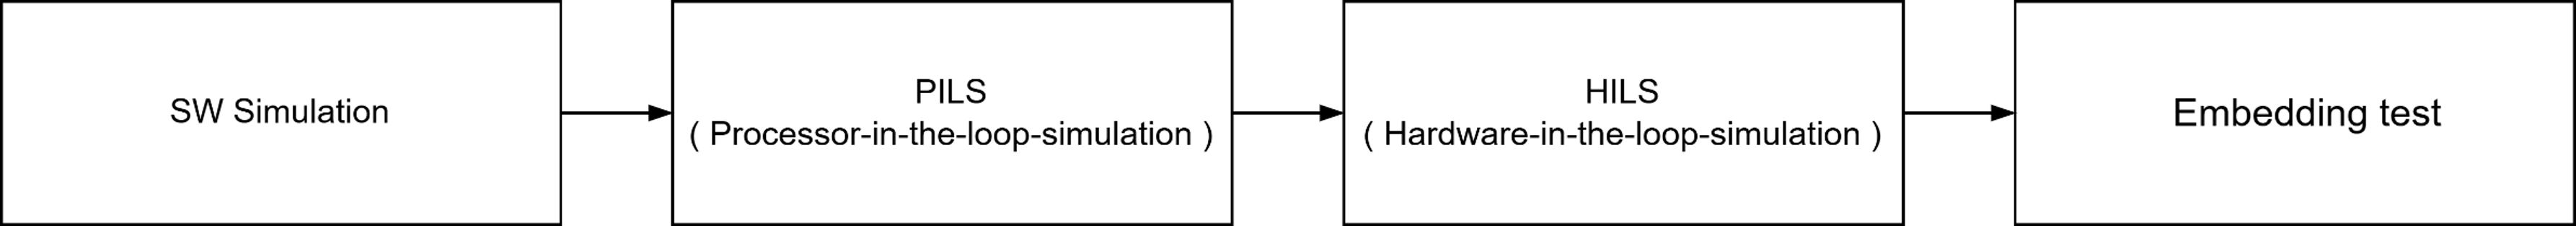

<br>


*   **Software simulation**

    The initial step involves simulating the proposed control system in conjunction with the plant model on a single personal computer.

*   **Processor-in-the-Loop-Simulation (PILS)**
  
    Subsequently, during the Processor-in-the-Loop Simulation (PILS) phase, the control system is embedded onto a mission-specific PC and simulated within an environment integrated with a simulator PC.

*   **Hardware-in-the-Loop-Simulation (HILS)**

    Next, in the Hardware-in-the-Loop Simulation (HILS) phase, the control system’s performance is evaluated under conditions that closely emulate the real-world environment.
  
*   **Embedding test**

    Finally, the control system undergoes an embedding test, concluding the development process.



<br>

In general, a control system for regulating a plant is structured as follows.

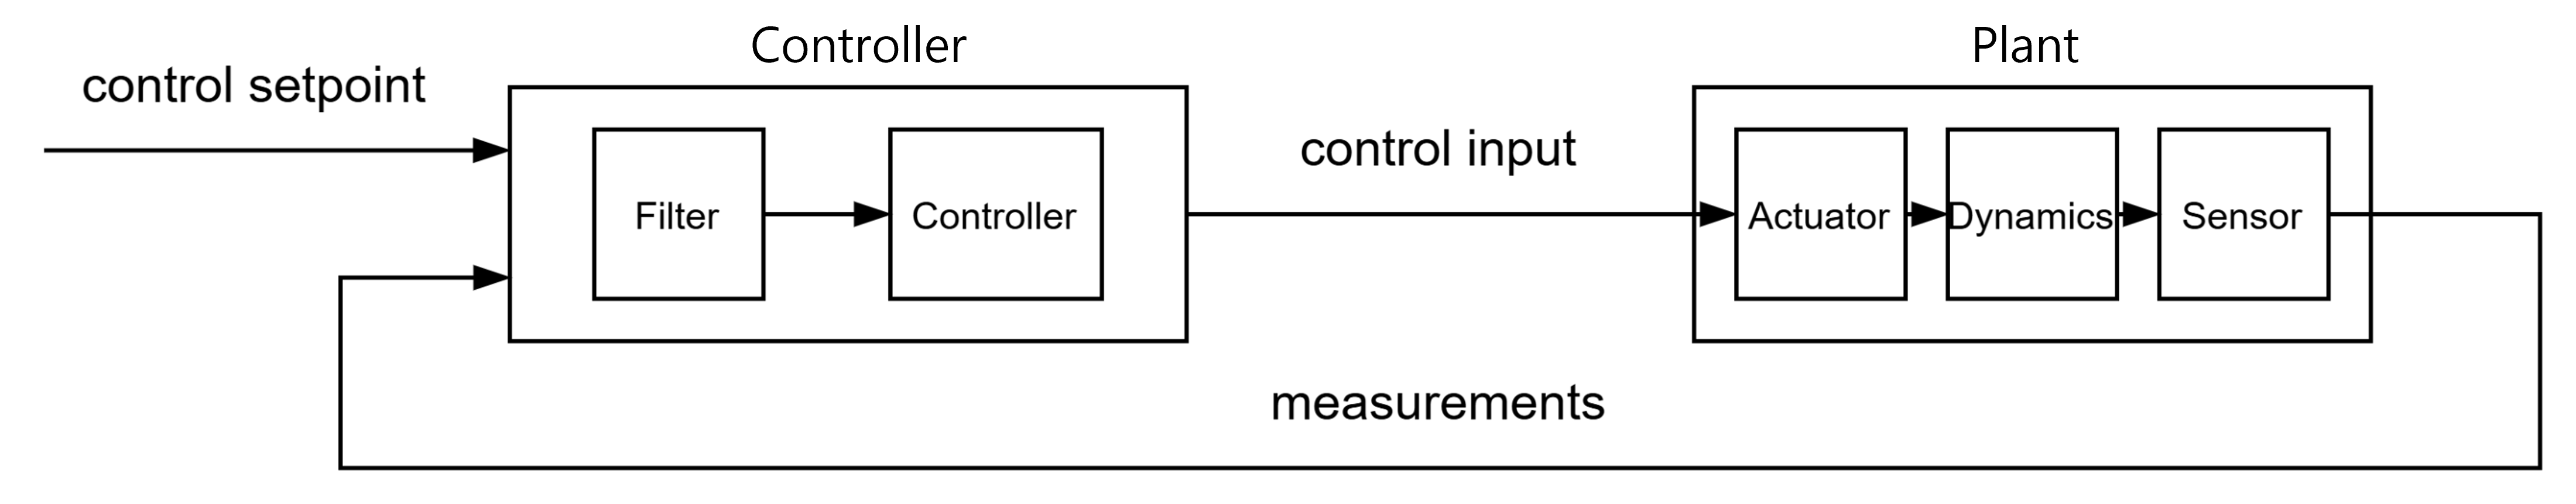

<br>

To conduct simulations for the verification of a control system, it is necessary to design the elements of the overall control system illustrated above.

<br>

---

<br>

## Plant modeling



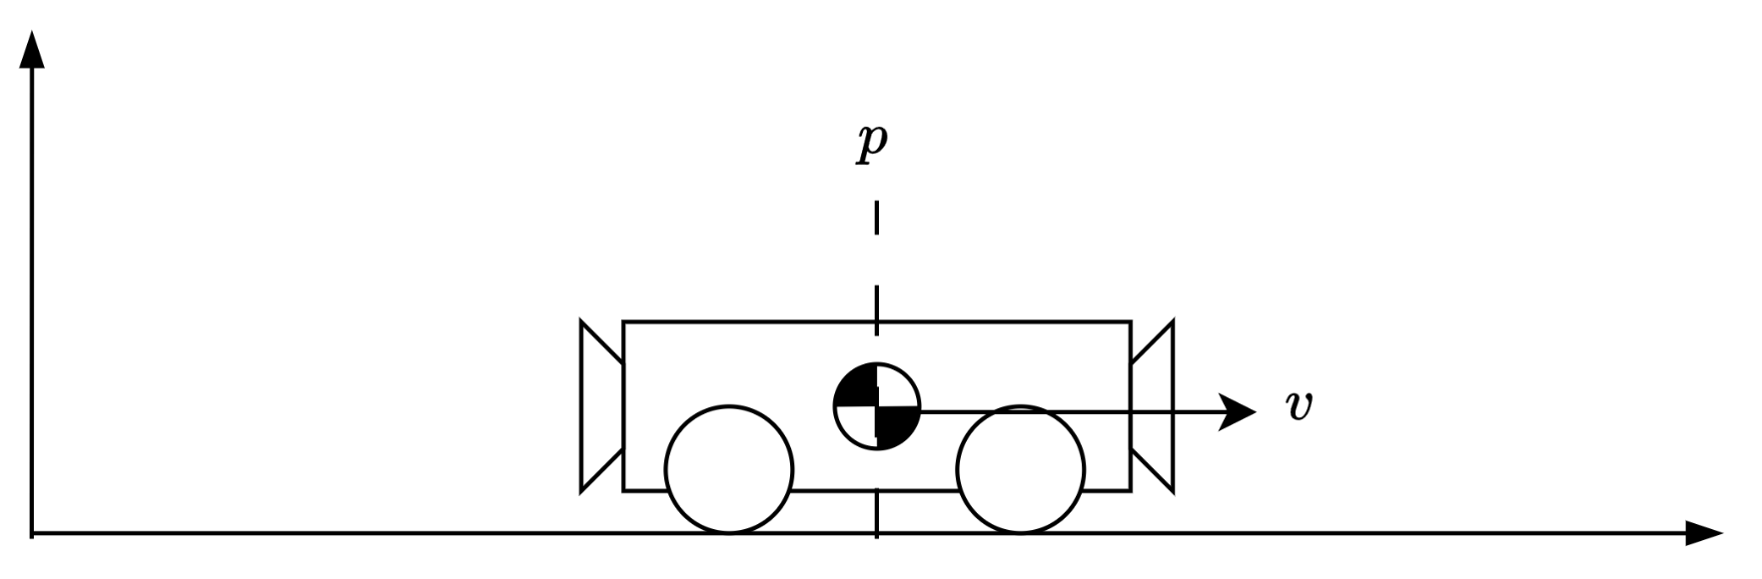

To design a control system, the primary step is to obtain the plant model.
As an example, consider a simple car model equipped with a thruster.

The state variables and control input are defined as follows:

$$
x=\begin{bmatrix}p\\v\end{bmatrix},\; u={F\over m},
$$

where $ p $, $ v $, $ F $ and $ m $ denote the position, velocity, thrust and mass of the car, respectively. Ignoring friction and assuming the aerodynamic drag of the car is $-\gamma v^2$, the dynamics of the car can be modeled as:

$$
\dot{x}=
\begin{bmatrix}
\dot{p}\\\dot{v}
\end{bmatrix}=
\begin{bmatrix}
v\\u-\gamma v^2
\end{bmatrix}\overset{\rm let}{=}
\begin{bmatrix}
f_p(x,u)\\f_v(x,u)
\end{bmatrix}.
$$

<br>

By numerically integrating this model, the state of the vehicle over time can be determined.

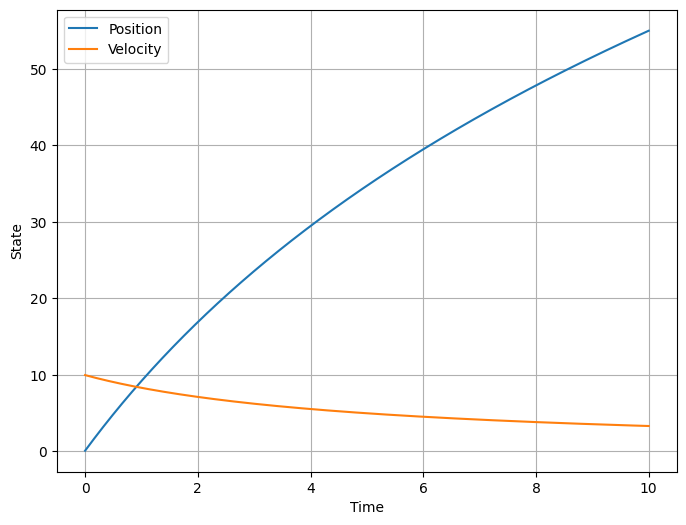

In [1]:
import numpy                as np
import matplotlib.pyplot    as plt

gamma = 0.02
v0    = 10.0

def system_dynamics(t, x, u):
    return np.array([x[1], u - gamma * x[1]**2])

def simulate_no_control(t_span, x0):
    t_values = []
    x_values = []

    x     = x0
    x_dot = np.zeros_like(x)

    dt    = 0.01
    t     = t_span[0]

    while t <= t_span[1]:

        x_dot = system_dynamics(t, x, u=0)

        x = x + x_dot * dt

        t_values.append(t)
        x_values.append(x)

        t += dt

    return np.array(t_values), np.array(x_values)

fig = plt.figure(figsize=(8, 6), dpi=100)
ax1 = fig.add_subplot(111)

t_values, x_values = simulate_no_control(t_span=[0, 10], x0=[0, 10])

ax1.plot(t_values, x_values[:, 0], label='Position')
ax1.plot(t_values, x_values[:, 1], label='Velocity')
ax1.set_xlabel('Time')
ax1.set_ylabel('State')
ax1.legend()
ax1.grid()
plt.show()



<br>

---

<br>

## Control design

<br>

### Plant linearization

<br>

Consider the cruise control scenario, where the car is traveling at a velocity  $v_0$, and the objective is to design a controller to maintain this velocity  $v_0$. To facilitate controller design, it is recommended to linearize the obtained dynamic model.

Since the drag term is nonlinear with respect to velocity, it must be linearized around small deviations ($\Delta x$) from the trim value ($x_0$) as follows:

$$
\begin{align*}
\\
\dot{\Delta x}=
\begin{bmatrix}
\dot{\Delta p}\\\dot{\Delta v}
\end{bmatrix}&\approx
\begin{bmatrix}
{\partial f_p \over \partial p}\Big|_{(x_0,u_0)} \Delta p  +  
{\partial f_p \over \partial v}\Big|_{(x_0,u_0)} \Delta v  +
{\partial f_p \over \partial u}\Big|_{(x_0,u_0)} \Delta u  \\
{\partial f_v \over \partial p}\Big|_{(x_0,u_0)} \Delta p  +  
{\partial f_v \over \partial v}\Big|_{(x_0,u_0)} \Delta v  +
{\partial f_v \over \partial u}\Big|_{(x_0,u_0)} \Delta u  
\end{bmatrix}\\\\
&=
\begin{bmatrix}
0 & 1 \\
0 & -2\gamma v_0
\end{bmatrix}
\begin{bmatrix}
\Delta p\\
\Delta v
\end{bmatrix} +
\begin{bmatrix}
0\\
1
\end{bmatrix}
\Delta u
\\\\
\end{align*}
$$

For this example, let the trim values be set as below. Here, $v_{\rm c}$ denotes the desired velocity for cruise control, which is set to $10\;{\rm m/s}$.

$$
p_0 = 0, \quad
v_0 = v_{\rm c}, \quad
u_0 = 0
$$

<br>

### Stability analysis

<br>

Using the linearized model, the stability and convergence of the control system can be analyzed.

In classical control theory, the stability of the control system is often analyzed in the  $s$-domain rather than the  $t$-domain. Consider a second-order differential equation:

$$
a\ddot{x} + b\dot{x} + c x = 0
$$

This leads to the characteristic equation:

$$
a s^2 + b s + c = 0
$$

The roots of the characteristic equation determine the system's response:

<br>

1.   Characteristic equation with two distinct real roots, $s=s_1, s_2$: \\
The general solution is:
$$
x(t) = C_1 e^{s_1 t} + C_2 e^{s_2 t}
$$
where $C_1$ and $C_2$ are constants determined by the initial conditions.

2.   Characteristic equation with repeated roots, $s$: \\
The general solution is:
$$
x(t) = (C_1 + C_2 t) e^{s t}
$$
where  C_1  and  C_2  are constants determined by the initial conditions.

3.   Characteristic equation with complex roots, $s=\alpha \pm j \beta$: \\
The general solution is:
$$
x(t) = e^{\alpha t} \left( C_1 \cos{(\beta t)} + C_2 \sin{(\beta t)} \right)
$$
where $\alpha$ is the real part and $\beta$ is the imaginary part of the roots, and $C_1$ and $C_2$ are constants determined by the initial conditions.

<br>

The general solution includes a term multiplied by $e^{s t}$, where the sign of $\text{Re}(s)$ (the real part of $s$) determines whether the solution converges or diverges. Stability is thus determined by the sign of the exponent in the exponential term.

Applying the Laplace transform, defined as:

$$
\mathbf{L}\{ f(t) \} = F(s) = \int^\infty_\infty f(t) e^{-st} dt  
$$

allows us to convert the differential equation into an algebraic equation, facilitating stability analysis in the $s$-domain.

<br>

For our example, focusing on the velocity variable, the linearized differential equation is:

$$
\Delta\dot{v} = \Delta u - 2\gamma v_0 \Delta v.
$$

Applying the Laplace transform yields:

$$
s \Delta V(s) = \Delta U(s) - 2\gamma v_0 \Delta V(s).
$$

Rearranging, we obtain the transfer function:

$$
\left( s + 2\gamma v_0 \right) \Delta V(s) = \Delta U(s) \quad \Rightarrow \quad G_v(s) = \frac{\Delta V(s)}{\Delta U(s)} = \frac{1}{s + 2\gamma v_0}.
$$

<br>

The poles of the transfer function, which are the values of $s$ that make the denominator zero, are critical for evaluating stability. For the system to be stable, these poles must have negative real parts.


<br>

Now, consider that the controller provides feedback on the velocity $\Delta v$ as follows.


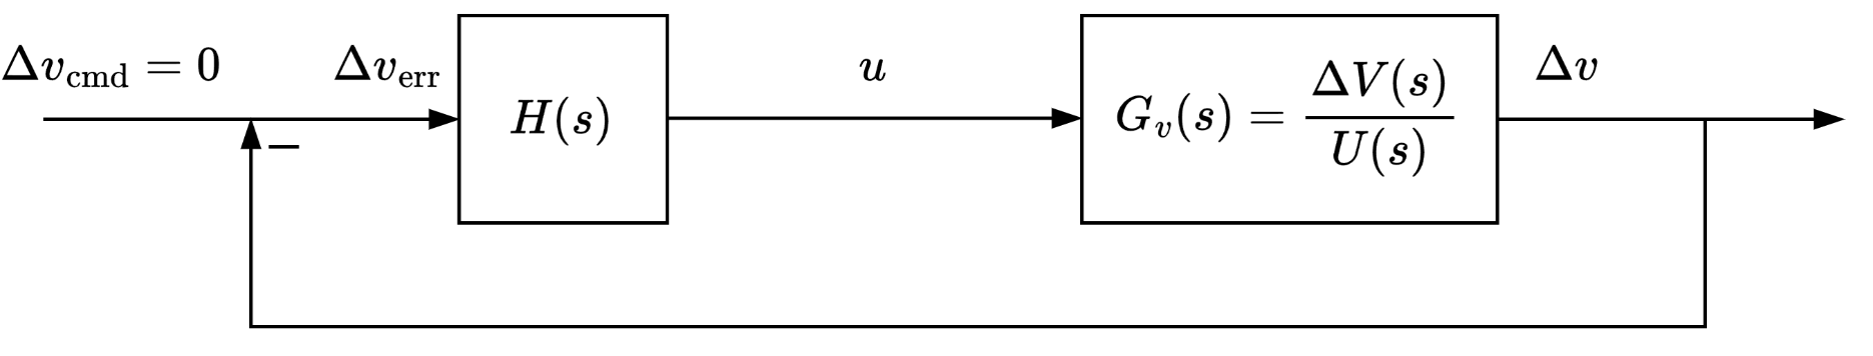

The objective now is to determine the controller $H(s)$ that ensures all poles of the overall control system have negative real parts, thereby guaranteeing system stability. We will utilize a Proportional-Integral (PI) controller, one of the fundamental controllers in classical control theory. The transfer function of the PI controller is given by:

$$
H(s) = K_p + \frac{K_i}{s}
$$

where $K_p$ is the proportional gain and $K_i$ is the integral gain.

<br>

By incorporating the PI controller, the overall control system can be represented as follows.

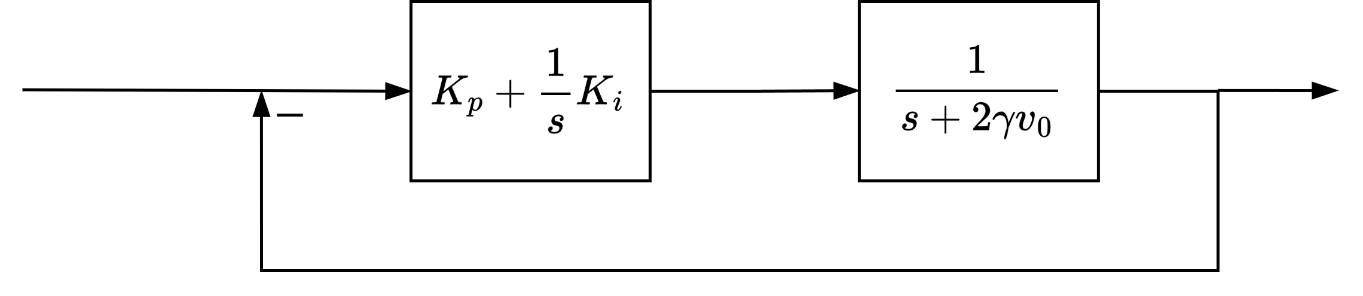

<br>

The transfer functions in the block diagram above can be simplified by representing them as the product of a gain $K$ and a transfer function $G(s)$.

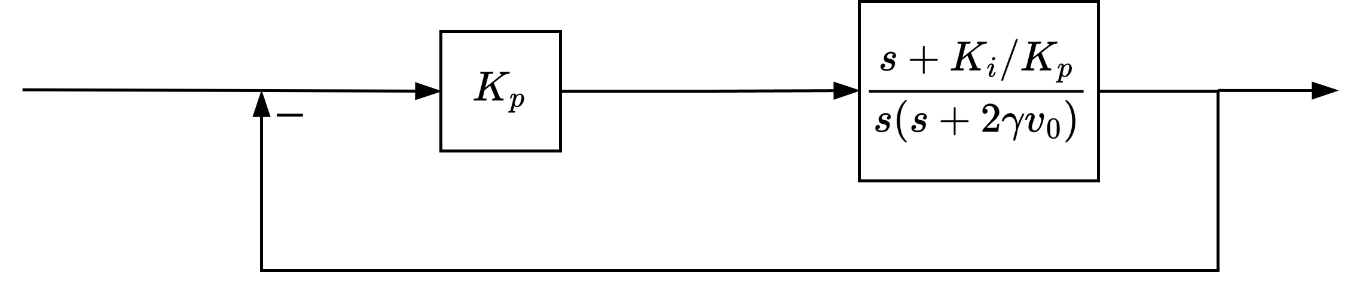

This simplification allows the entire closed-loop system to be expressed as a single transfer function, as shown.

$$
T(s) =
{ K_p \ \displaystyle{s+K_i/K_p \over s^2 + 2\gamma v_0 s} \over
1 + K_p \ \displaystyle{s+K_i/K_p \over s^2 + 2\gamma v_0 s}}
$$

<br>

The poles of this transfer function are referred to as 'closed-loop poles.' As the gain $K$ varies, the positions of these poles change accordingly. The trajectory of these shifting poles is known as the 'root locus,' which is a valuable tool for stability analysis.

In [3]:
!pip install control

<br>

The root locus for the control system is presented below, with the ratio $K_i / K_p = 10$ set.

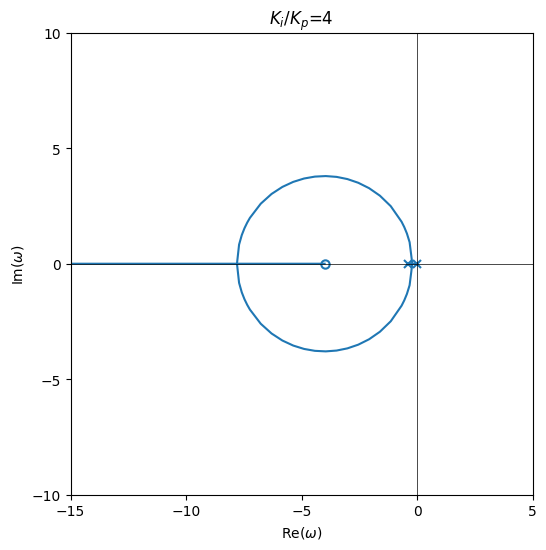

In [5]:
import control as ct
Ki_frac_Kp = 4

num = np.array([1, Ki_frac_Kp])
den = np.array([1, 2*gamma*v0, 0])
G = ct.tf(num, den)

fig = plt.figure(figsize=(9,6), dpi=100)
ax1 = fig.add_subplot(111)
ct.rlocus(G, ax=ax1, \
          title=r"Root locus for $H(s)=G_\tau(s)G_\theta(s)$")

ax1.set_title(rf"$K_i$/$K_p$={Ki_frac_Kp}")
ax1.set_xlabel(r"Re$(\omega)$")
ax1.set_ylabel(r"Im$(\omega)$")
ax1.set_xticks(np.arange(-50, 11, 5))
ax1.set_yticks(np.arange(-30, 31, 5))
ax1.set_xlim([-15, 5])
ax1.set_ylim([-10, 10])
ax1.hlines(0, -15, 5, color="k", linewidth=0.5)
ax1.vlines(0, -10, 10, color="k", linewidth=0.5)
ax1.set_box_aspect(1)

plt.show()

<br>

The values of $s$ that make the numerator equal to zero are referred to as 'zeros,' analogous to the poles that make the denominator zero. Zeros influence the trajectory of the poles as the gain $K$ varies. In this example, the PI controller introduces a zero at  $s = -{K_i}/{K_p}$.

By leveraging this zero, we can modify the trajectory of the poles in the root locus. By selecting a gain that positions the poles at locations along this trajectory that ensure both stability and high responsiveness, the desired control performance can be achieved. For example, when the gain $K_p$ is set to $2$, the poles are located as shown below.

/Users/hoony/pyenv311/lib/python3.11/site-packages/control/rlocus.py:202: FutureWarning: root_locus() return value of roots, gains is deprecated; use root_locus_map()
  warnings.warn(


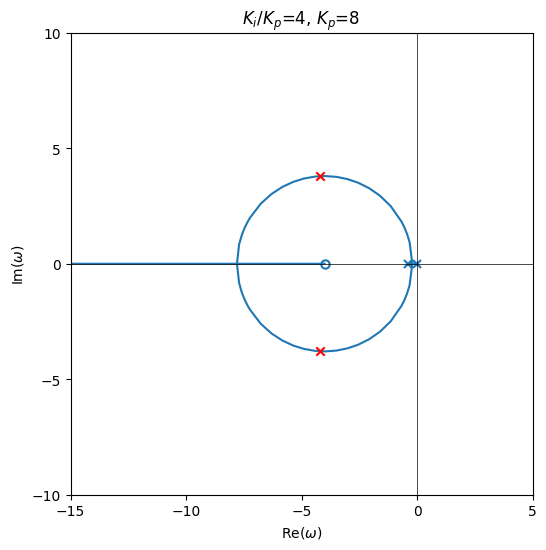

In [7]:
Kp = 8

fig = plt.figure(figsize=(9,6), dpi=100)
ax1 = fig.add_subplot(111)
ct.rlocus(G, ax=ax1, \
          title=r"Root locus for $H(s)=G_\tau(s)G_\theta(s)$")

ax1.set_title(rf"$K_i$/$K_p$={Ki_frac_Kp}, $K_p$={Kp}")
ax1.set_xlabel(r"Re$(\omega)$")
ax1.set_ylabel(r"Im$(\omega)$")
ax1.set_xticks(np.arange(-50, 11, 5))
ax1.set_yticks(np.arange(-30, 31, 5))
ax1.set_xlim([-15, 5])
ax1.set_ylim([-10, 10])
ax1.hlines(0, -15, 5, color="k", linewidth=0.5)
ax1.vlines(0, -10, 10, color="k", linewidth=0.5)
ax1.set_box_aspect(1)

poles, _ = ct.rlocus(G, gains=Kp, plot=False)
ax1.scatter(poles.real, poles.imag, color="r", marker="x", zorder=10)

plt.show()

<br>

Now, let us implement the PI controller with these gain values and simulate its performance.

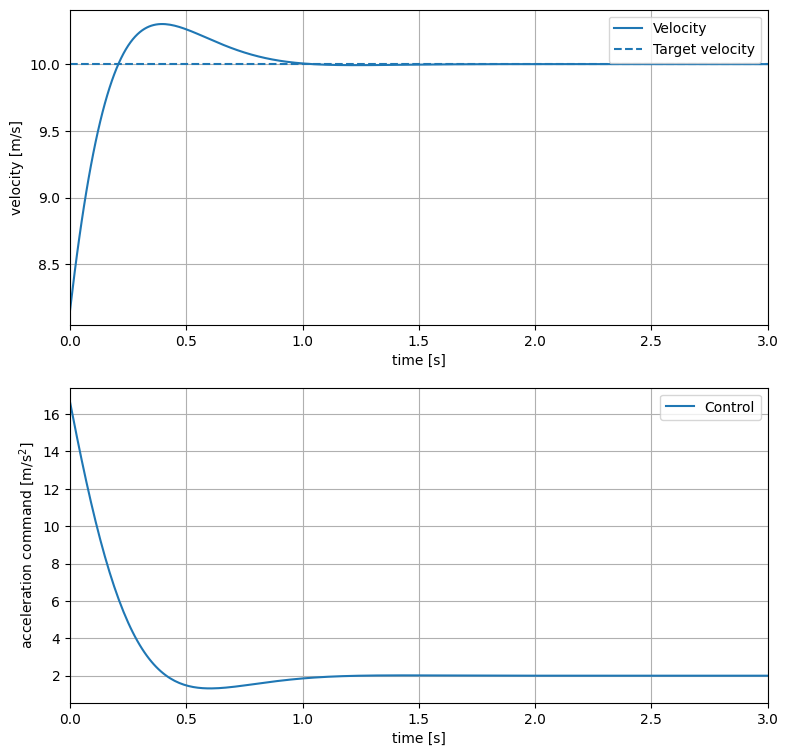

In [8]:
from re import U
Ki = Kp * Ki_frac_Kp

def control_input(x, x_target, var_cum, Kp, Ki):
    error = x_target - x
    var_cum += error * 0.01
    u = Kp * error + Ki * var_cum
    return u, var_cum

def simulate_PI_control(t_span, x_target, x0, Kp, Ki):
    t_values = []
    x_values = []
    u_values = []

    x     = x0
    x_dot = np.zeros_like(x)
    var_cum = 0

    dt    = 0.01
    t     = t_span[0]

    while t <= t_span[1]:

        u, var_cum = control_input(x[1], x_target[1], var_cum, Kp, Ki)

        x_dot = system_dynamics(t, x, u)

        x = x + x_dot * dt

        t_values.append(t)
        x_values.append(x)
        u_values.append(u)

        t += dt

    return np.array(t_values), np.array(x_values), np.array(u_values)

t_values, x_values, u_values = simulate_PI_control( \
          t_span=[0, 3], x_target=[0,10], x0=[0, 8], Kp=Kp, Ki=Ki)

fig = plt.figure(figsize=(9, 9), dpi=100)
ax1 = fig.add_subplot(211)
ax1.plot(t_values, x_values[:, 1], label='Velocity')
ax1.hlines(10, 0, 3, linestyle='--', label='Target velocity')
ax1.set_xlabel('time [s]')
ax1.set_ylabel('velocity [m/s]')
ax1.set_xlim([0,3])
ax1.grid()
ax1.legend()
ax2 = fig.add_subplot(212)
ax2.plot(t_values, u_values, label='Control')
ax2.set_xlabel('time [s]')
ax2.set_ylabel(r'acceleration command [m/s$^2$]')
ax2.set_xlim([0,3])
ax2.grid()
ax2.legend()
plt.show()